# Classification Workflow with Pipelines

Let's add pipelines into our workflow!

In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.dummy import DummyClassifier

In [19]:
titanic = pd.read_csv('./data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
X = titanic.drop(['PassengerId', 'Name', 'Survived'], axis=1)
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Using `Pipeline` and `FunctionTransformer`

Let's try a very simple pipeline first.

In [21]:
def grab_numeric(df):
    return df.select_dtypes(include=['float', 'int'])

In [22]:
# The FunctionTransformer will turn my function
# into a transformer.

GrabNumeric = FunctionTransformer(grab_numeric)

In [23]:
# Pipe!

pipe = Pipeline([
    ('num', GrabNumeric),
    ('ss', StandardScaler())
])

That looks like it worked!

## Using `Pipeline` and `ColumnTransformer`

When we use the `ColumnTransformer` we'll want to choose the relevant column numbers, so let's remind ourselves which columns are where:

In [24]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S


In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Ticket    891 non-null    object 
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 62.8+ KB


In [36]:
X_demo = X.copy()

In [37]:
X_demo.Pclass = X_demo.Pclass.astype(object) 

# Change datatype to object so its captured in cat_pipe not num_pipe

In [26]:
# We'll throw these mini-pipelines into our ColumnTransformer: numeric and categorical


# numbers (Age, Fare, SibSp, Parch)
  # Nulls -->
    # scale, impute 

# categorical (sex, embarked, pclass)
# OHE, impute

In [27]:
# Numeric Pipeline

num_pipe = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler()),
])

In [30]:
# Categorical Pipeline

cat_pipe = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')) 
    # last parameter (of above) is standard for pipelines
])

### Selector!!!!

[This](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html#sklearn.compose.make_column_selector) will return a callable list of columns

In [31]:
# Selector!

test = selector(dtype_include=object)

In [32]:
test(X)

['Sex', 'Ticket', 'Cabin', 'Embarked']

In [33]:
#format of transfomers = ['name', 'transformer', 'columns']

CT = ColumnTransformer(transformers=[
    ('num_tr', num_pipe, selector(dtype_include=np.number)),
    ('cat_tr', cat_pipe, selector(dtype_include=object)),
], remainder='passthrough')

# The "remainder='passthrough'" bit tells the compiler to leave
# the other df columns unchanged.

In [ ]:
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.


## Bringing in Our Modeling Class from before

In [38]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [41]:
# Create Dummy/Baseline

dummy_model = Pipeline([
    ('ct', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [43]:
# Use the class with out dummy pipe

dummy_model_pipe = ModelWithCV(dummy_model, model_name = 'dummy', X=X_train, y=y_train)

In [45]:
dummy_model_pipe.print_cv_summary()

CV Results for `dummy` model:
            0.62126 ± 0.00646 accuracy
        


<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

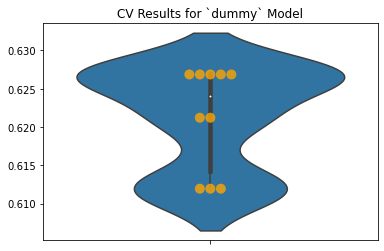

In [46]:
fig, ax = plt.subplots()

dummy_model_pipe.plot_cv(ax=ax)

In [49]:
# Create FSM (First Simple Model)

logreg = Pipeline([
    ('ct',CT),
    ('logreg', LogisticRegression(random_state=42))
])

In [50]:
fsm_model_pipe = ModelWithCV(logreg, model_name = 'fsm', X=X_train, y=y_train)

In [ ]:
# Use the class with out logreg pipe


## Trying Other Models at the End of the Pipeline

Can I have multiple models in a single pipeline? Yes. We'll forgo this here, but for more on this see [here](https://stackoverflow.com/questions/48507651/multiple-classification-models-in-a-scikit-pipeline-python).

### Random Forest

<AxesSubplot:title={'center':'CV Results for `forest_pipe` Model'}>

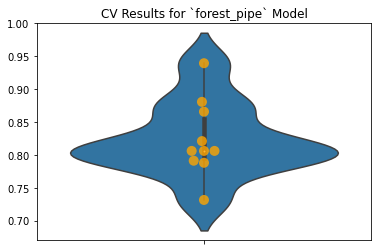

In [52]:
# rfc!

rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([
    ('ct', CT),
    ('rfc', rfc)
])

forest_pipe = ModelWithCV(model=rfc_model_pipe,
                         model_name="forest_pipe",
                         X=X_train,
                          y=y_train)

fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax)

### Gradient Booster

In [ ]:
# gbc!

gbc_model_pipe = Pipeline([
    ('ct', CT), 
    ('gbc', GradientBoostingClassifier(random_state=42))
])

gbc_pipe = ModelWithCV(model=gbc_model_pipe,
                       model_name="gbc_pipe",
                       X=X_train,
                       y=y_train)

fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax)

## Tuning and Cross-Validating

In [53]:
# GridSearch?

rfc_model_pipe

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_tr',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc098521700>),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   One

In [ ]:
SimpleImputer()

In [56]:
params = {
    'ct__num_tr__num_impute__strategy' : ['mean', 'median'],
    'rfc__criterion':['gini','entropy'],
    'rfc__max_depth':[1,3,5]
}

In [57]:
gs = GridSearchCV(estimator=rfc_model_pipe, param_grid=params, cv=10, verbose=2)

In [58]:
gs.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] ct__num_tr__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_tr__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.1s
[CV] ct__num_tr__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ct__num_tr__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.1s
[CV] ct__num_tr__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_tr__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.1s
[CV] ct__num_tr__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_tr__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.1s
[CV] ct__num_tr__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_tr__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.1s
[CV] ct__num_tr__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_tr__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.1s
[CV] ct__num_tr__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_tr__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   0.

[CV]  ct__num_tr__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   0.1s
[CV] ct__num_tr__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3 
[CV]  ct__num_tr__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   0.1s
[CV] ct__num_tr__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3 
[CV]  ct__num_tr__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   0.1s
[CV] ct__num_tr__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=5 
[CV]  ct__num_tr__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=5, total=   0.1s
[CV] ct__num_tr__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=5 
[CV]  ct__num_tr__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=5, total=   0.1s
[CV] ct__num_tr__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=5 
[CV]  ct__num_tr__num_impute__strategy=mean, rfc__criterion=entro

[CV]  ct__num_tr__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1, total=   0.1s
[CV] ct__num_tr__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_tr__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1, total=   0.1s
[CV] ct__num_tr__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_tr__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1, total=   0.1s
[CV] ct__num_tr__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_tr__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1, total=   0.1s
[CV] ct__num_tr__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_tr__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1, total=   0.1s
[CV] ct__num_tr__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_tr__num_impute__strategy=median

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   11.7s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_tr',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc098521700>),
                                                                        ('cat_tr',
                                                                         Pipeline(steps=[('cat_impute',
   

In [59]:
gs.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_tr',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc079ffbe20>),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   One

In [60]:
gs.best_params_

{'ct__num_tr__num_impute__strategy': 'mean',
 'rfc__criterion': 'entropy',
 'rfc__max_depth': 5}

In [61]:
gs.best_score_

0.7724332881049298

In [62]:
gs.best_estimator_.score(X_test, y_test)

0.757847533632287

In [64]:
params2 = {
    'rfc__criterion':['entropy'],
    'rfc__max_depth':[5,7,9,11]
}

In [65]:
gs = GridSearchCV(estimator=rfc_model_pipe, param_grid=params2, cv=10, verbose=1)

In [66]:
gs.fit(X_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    4.4s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_tr',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc098521700>),
                                                                        ('cat_tr',
                                                                         Pipeline(steps=[('cat_impute',
   

In [68]:
gs.best_params_

{'rfc__criterion': 'entropy', 'rfc__max_depth': 11}

In [ ]:
# Can show this iteration as "Grid Search returned these results, 
# so these were the final parameters "
# can say the # of iterations we went through 

# See Youtube video @ 13 min after break 

In [69]:
gs.best_score_

# Mean test score for each of six models

0.8129127091813659

## `imblearn` Pipelines

### Dealing with the Target Imbalance

Let's use `SMOTE()`:

In [71]:
y_train.value_counts(normalize=True)

0    0.621257
1    0.378743
Name: Survived, dtype: float64

In [72]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

In [73]:
sm2 = SMOTE(sampling_strategy=0.8, random_state=42)

To make things simple (and avoid errors!), let's just grab the numeric types and eliminate the NaNs from X_train:

In [74]:
X_train_clean = X_train.select_dtypes(['float', 'int']).dropna()
y_train_clean = y_train[X_train_clean.index]

In [75]:
y_train_clean.value_counts()

0    317
1    219
Name: Survived, dtype: int64

In [77]:
# Even distribution

X_clean_resmp, y_clean_resmp = sm.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp.value_counts()

1    317
0    317
Name: Survived, dtype: int64

In [78]:
# Distribution where count of 1's = 0.8 * count of 0's

X_clean_resmp2, y_clean_resmp2 = sm2.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp2.value_counts()

0    317
1    253
Name: Survived, dtype: int64

### `imblearn` Pipeline

Of course, we want to be able to perform all of our preprocessing steps from above, but just now add `SMOTE`. Good thing we can throw it all into a pipeline!

In [80]:
# imbpipe!

imb_pipe = ImPipeline(steps=[
    ('CT', CT),
    ('sm', SMOTE(random_state=42)),
    ('rfc', RandomForestClassifier(random_state=42))
])

In [81]:
imb_pipe.fit(X_train, y_train)

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_tr',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc098521700>),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   One

In [82]:
imb_pipe.score(X_train, y_train)

0.9985029940119761

In [83]:
imb_pipe.score(X_test, y_test)

0.8116591928251121

### Gridsearching

In [85]:
# Seriously? Again?

params = {
    'rfc__criterion':['gini','entropy'],
    'rfc__min_samples_leaf':[1,5,10],
    'sm__k_neighbors':[3,5,9]
}

gs = GridSearchCV(estimator=imb_pipe, param_grid=params)

#SMOTE has to be used with the IMB Pipeline

In [87]:
gs.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

## Evaluation on Test Set

Let's suppose that we choose our final model from this last GridSearch run. Note that the optimal parameters are also the default values!

In [95]:
final_model = imb_pipe

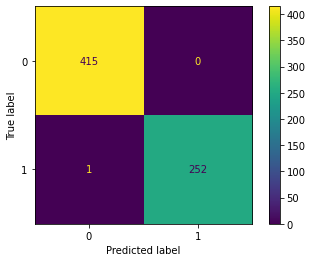

In [98]:
plot_confusion_matrix(final_model, X_train, y_train);

In [99]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_train, y_hat_train), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_train, y_hat_train), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_train, y_hat_train), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_train, y_hat_train), 2)}.
""")


Our final model's accuracy on the test set is 1.0. 

Our final model's recall on the test set is 1.0 

Our final model's precision on the test set is 1.0 

Our final model's f1-score on the test is 1.0.



In [93]:
y_hat_train = final_model.predict(X_train)

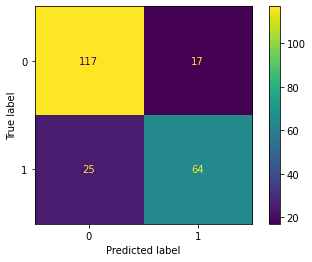

In [89]:
plot_confusion_matrix(final_model, X_test, y_test);

In [90]:
y_hat = final_model.predict(X_test)

In [91]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.81. 

Our final model's recall on the test set is 0.72 

Our final model's precision on the test set is 0.79 

Our final model's f1-score on the test is 0.75.



## Exercise: Your Turn!

Use SMOTE and an estimator (model) of your choice in a pipeline to model the exoplanets' method of discovery ("method"). You can build a model one feature at a time or just throw them all in from the beginning. Consider using the LabelEncoder (from sklearn.preprocessing) to code up the target. You'll also need to make a choice about how to handle the null values.

In [ ]:
exos = sns.load_dataset('planets')

In [ ]:
### Your work here






